# **STUDENT AI** - EDA
Exploratory Data Analysis

## Objectives

Conduct Exploratory analysis of the data to glean insights into how it might be used to solve the business case. Final objective is to identify significant variables to train the model on.

## Inputs

Cleaned Dataset from previous notebook.

## Outputs

None


### Install new libraries needed for EDA

---

# Import required libraries

In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import ppscore as pps
import pingouin as pg
import pickle
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from IPython.display import display, Markdown
from feature_engine import transformation as vt
from sklearn.pipeline import Pipeline
from pandas.plotting import table
sys.path.append('/workspace/student-AI/src')
from data_management import save_plot, save_df, save_analysis

print('All Libraries Loaded')

# set default diagram size for matplotlib
plt.rcParams['figure.figsize'] = [3, 3]
colors = ['red', 'blue', 'green', 'orange', 'purple','yellow']

All Libraries Loaded


# Load Clean Dataset

### Set the working directory to notebook parent folder
If the output does not match, click **'clear all outputs'** and then **'restart'** the notebook. 
Then run cells from top to bottom.

In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('If correct, Active Directory should read: /workspace/student-AI')
print(f"Active Directory: {current_dir}")

If correct, Active Directory should read: /workspace/student-AI
Active Directory: /workspace/student-AI


## Enable / Disable Plot Saving & Updating
Set the variable below to **True** if you want to save generated plots to disk. Old versions will be overwritten!
The saved files are linked to the streamlit app and any updates will be displayed there.
To update plots in deployed version remember to commit/push and re-deploy app.

Keep Variable **False** if you just want to test different plots without saving any updates.

**Remember to re-run the cell if you change the value**

In [3]:
save_to_disk = False

### Load cleaned dataset

In [4]:
df = pd.read_csv(f"outputs/dataset/Expanded_data_with_more_features_clean.csv")
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,C,bachelor,standard,not completed,married,regularly,yes,3,schoolbus,Less than 5 hours,71,71,74
1,female,C,college,standard,not completed,married,sometimes,yes,0,schoolbus,Between 5-10 hours,69,90,88
2,female,B,masters,standard,not completed,single,sometimes,yes,4,schoolbus,Less than 5 hours,87,93,91
3,male,A,associates,free,not completed,married,never,no,1,schoolbus,Between 5-10 hours,45,56,42
4,male,C,college,standard,not completed,married,sometimes,yes,0,schoolbus,Between 5-10 hours,76,78,75


### Add mean score to be able to compare all 3 scores as a single value against the features

In [5]:
df['MeanScore'] = df[['MathScore', 'ReadingScore', 'WritingScore']].mean(axis=1).round().astype(int)
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore,MeanScore
0,female,C,bachelor,standard,not completed,married,regularly,yes,3,schoolbus,Less than 5 hours,71,71,74,72
1,female,C,college,standard,not completed,married,sometimes,yes,0,schoolbus,Between 5-10 hours,69,90,88,82
2,female,B,masters,standard,not completed,single,sometimes,yes,4,schoolbus,Less than 5 hours,87,93,91,90
3,male,A,associates,free,not completed,married,never,no,1,schoolbus,Between 5-10 hours,45,56,42,48
4,male,C,college,standard,not completed,married,sometimes,yes,0,schoolbus,Between 5-10 hours,76,78,75,76


## Individual Feature Analysis vs Target Variables (Math, Reading & Writing Score)
Running these cells will calculate several plots for each column variable.<br>
All data is also saved and overwritten to disk so that it is automatically updated in the streamlit dashboard.

In [6]:
# define custom function to plot categorical variables based on column name
def plot_category_distribution(column):
    
    categories = df[column].sort_values().unique()
    palette = 'Set2'
    sns.set_palette(palette)
    sns.countplot(x=column, data=df, order=categories)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    if save_to_disk:
        save_plot(plt, f'{column}-distribution.png')
    plt.show()

    # Create a figure and 4 subplots
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))

    # Box plots
    sns.boxplot(ax=axs[0], x=column, y='MathScore', data=df, order=categories)
    axs[0].set_title('Math Score')
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

    sns.boxplot(ax=axs[1], x=column, y='ReadingScore', data=df, order=categories)
    axs[1].set_title('Reading Score')
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')

    sns.boxplot(ax=axs[2], x=column, y='WritingScore', data=df, order=categories)
    axs[2].set_title('Writing Score')
    axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')
    
    sns.boxplot(ax=axs[3], x=column, y='MeanScore', data=df, order=categories)
    axs[3].set_title('Mean Score')
    axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    if save_to_disk:
        save_plot(plt, f'{column}-boxplot.png')
    plt.show()

    # print scores compared to the given feature
    df_grouped = df.groupby([column])[['MathScore', 'ReadingScore', 'WritingScore', 'MeanScore']].agg(np.mean)
    df_sorted = df_grouped.sort_values(by='MeanScore', ascending=False)

    styled_df = df_sorted.style.background_gradient(cmap='Blues')
    display(styled_df)
    if save_to_disk:
        save_df(df_sorted, f'{column}-data.pkl')

    mean_max = df_sorted['MeanScore'].iloc[0]
    mean_min = df_sorted['MeanScore'].iloc[-1]
    spread = mean_max - mean_min
    spread_rounded = round(spread, 2)
    print(f'Mean Range: {spread_rounded}')

    if save_to_disk:
        print('')
        print('** SAVING DATA IS ENABLED **')
        print(f'{column}-distribution saved/updated.')
        print(f'{column}-boxplot saved/updated.')
        print(f'{column}-data saved/updated.')
    else:
        print('')
        print('** SAVING DATA IS DISABLED **')

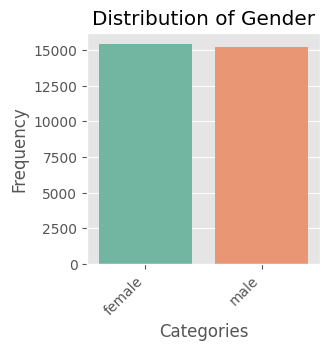

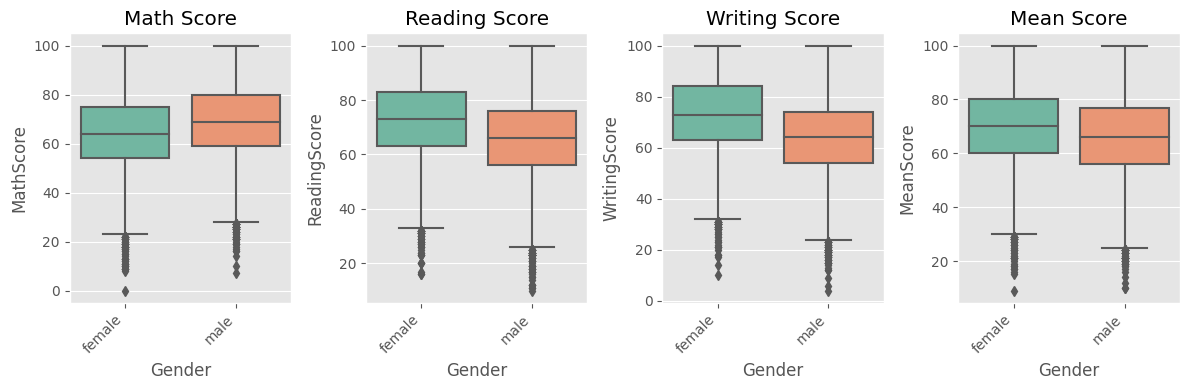

,MathScore,ReadingScore,WritingScore,MeanScore
Gender,,,,
female,64.080654,72.853216,72.856457,69.928683
male,69.069856,65.854571,63.920418,66.280147


Mean Range: 3.65

** SAVING DATA IS DISABLED **


In [11]:
plot_category_distribution('Gender')

In [12]:
column = 'Gender'

analysis = f"""This shows that the expected distribution of {column} among 
        students.
        The mean shows that female students on average have better results,
        but specifically for Maths that fact is reversed.
        With a difference of only 3 percent average score, the effect of 
        {column} however, is **not** a major contributing factor to overall 
        score."""

display(Markdown(analysis))   

if save_to_disk:         
        save_analysis(analysis, f'{column}-analysis.txt')

This shows that the expected distribution of Gender among 
        students.
        The mean shows that female students on average have better results,
        but specifically for Maths that fact is reversed.
        With a difference of only 3 percent average score, the effect of 
        Gender however, is **not** a major contributing factor to overall 
        score.

#### The data is well balanced and shows that females have an overall better performance, but tend to have lower maths skills.
**I hypothesize that gender will not have a very large impact on the predicted score.**

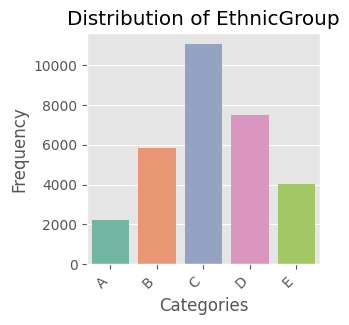

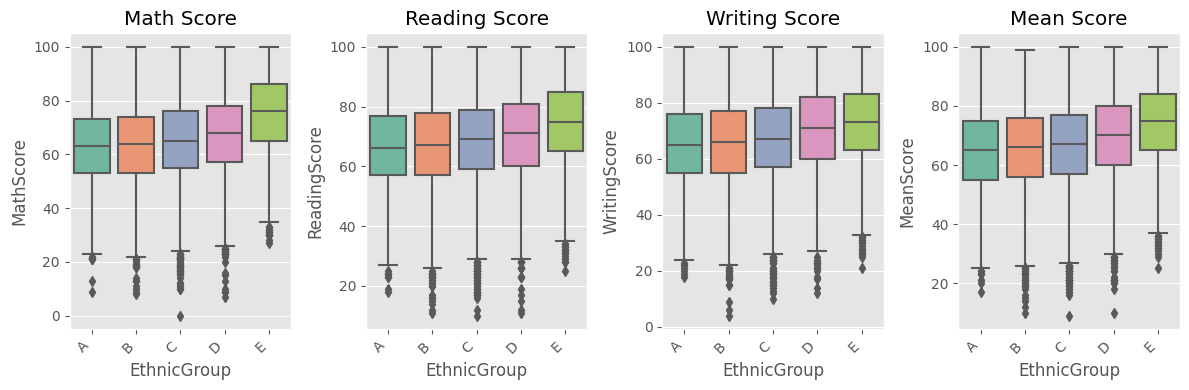

,MathScore,ReadingScore,WritingScore,MeanScore
EthnicGroup,,,,
E,75.298936,74.251423,72.677060,74.074487
D,67.666400,70.382247,70.890844,69.640944
C,64.943811,68.517734,67.149294,66.873326
B,63.490216,67.320460,65.895125,65.567285
A,62.991888,66.787742,65.251915,65.000000


Mean Range: 9.07

** SAVING DATA IS DISABLED **


In [13]:
plot_category_distribution('EthnicGroup')

#### This data is not balanced as group C far outnumbers group A ... this will need to be adjusted prior to training the models, as it would unfarely give group C a higher significance in predicting the student performance.

Group E shows the highest mean score and is significantly better performing in school.<br>
Group A shows the least performance with a mean score almost 10% lower.<br>

**I hypothesize that Ethnic Group should have a significant influence on the predicted score.**

In [14]:
column = 'EthnicGroup'

analysis = f"""Shows that group C is the clear majority in this specific school,
    and group A is the clear minority.
    However, Group E, the second minority, is significantly better
    than the other groups, while GroupA performs the worst.
    With a difference of 9 percent on average, it is clear that {column}
    has a significant influence on the overall score of a student."""
display(Markdown(analysis))     
if save_to_disk:
    save_analysis(analysis, f'{column}-analysis.txt')

Shows that group C is the clear majority in this specific school,
    and group A is the clear minority.
    However, Group E, the second minority, is significantly better
    than the other groups, while GroupA performs the worst.
    With a difference of 9 percent on average, it is clear that EthnicGroup
    has a significant influence on the overall score of a student.

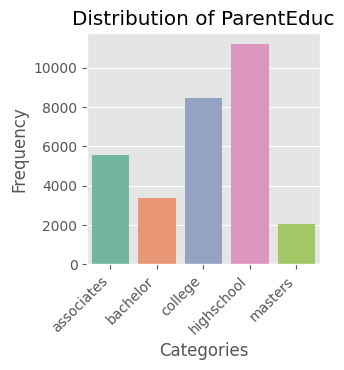

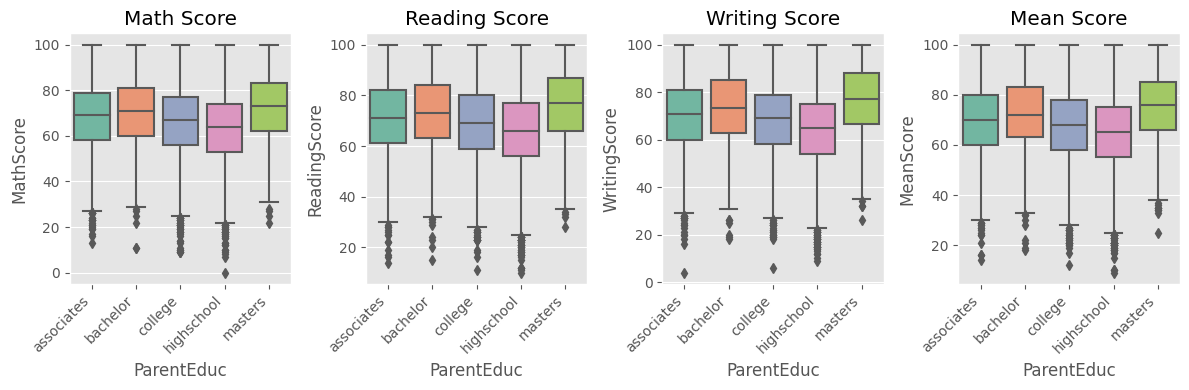

,MathScore,ReadingScore,WritingScore,MeanScore
ParentEduc,,,,
masters,72.336134,75.832921,76.356896,74.839348
bachelor,70.466627,73.062020,73.331069,72.281748
associates,68.365586,71.124324,70.299099,69.931712
college,66.445978,69.189667,68.456711,68.026303
highschool,63.523920,66.375312,64.540343,64.813549


Mean Range: 10.03

** SAVING DATA IS DISABLED **


In [15]:
plot_category_distribution('ParentEduc')

#### This data is not balanced and will need to be adjusted prior to training the models, as it would unfarely give students with parents with some college higher emphasis in predicting the student performance.

Parents with a masters degree have the lowest frequency, but tend to have children that outperform all other students.

**I hypothesize that parental education should have a significant influence on the predicted score.**

In [16]:
column = 'ParentEduc'

analysis = """This shows that Parental Education plays a significant role in
 the students performance with a Mean spread of 10. Students who'se parents
have a masters degree on average are 10 percent better than students with 
parents who only completed high school."""
display(Markdown(analysis))     
if save_to_disk:
    save_analysis(analysis, f'{column}-analysis.txt')

This shows that Parental Education plays a significant role in
 the students performance with a Mean spread of 10. Students who'se parents
have a masters degree on average are 10 percent better than students with 
parents who only completed high school.

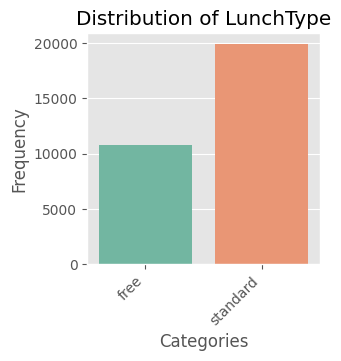

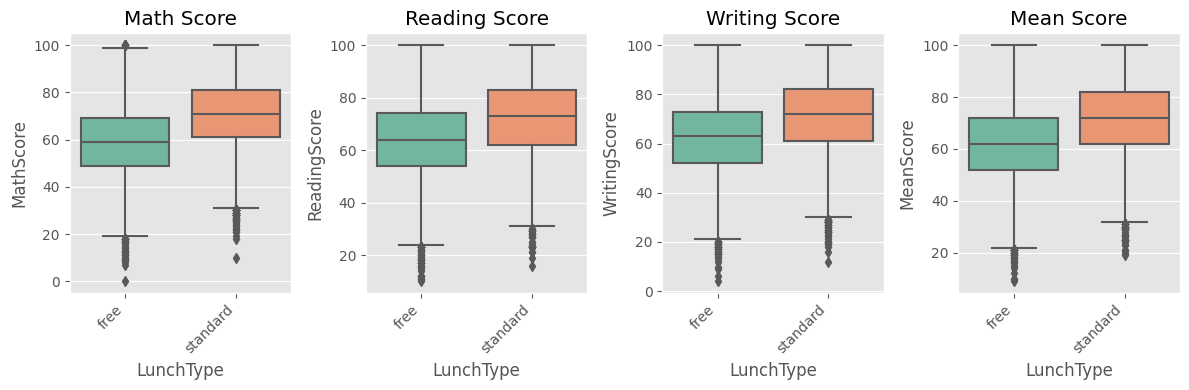

,MathScore,ReadingScore,WritingScore,MeanScore
LunchType,,,,
standard,70.709370,72.175634,71.529716,71.469982
free,58.862332,64.189735,62.650522,61.899683


Mean Range: 9.57

** SAVING DATA IS DISABLED **


In [17]:
plot_category_distribution('LunchType')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students who receive a standard lunch.

Students who receive a lunch from their parents (standard) are on average 10% better then students who do not. This is a very generalized indicator of economic well being of the family.<br>
the assumption can be made that parents who do not need to rely on free school lunch programs can afford not only a bespoke lunch meal, but also other benficiary activities such as purchasing study guides, better access to internet / PCs, tutoring etc.

**I hypothesize that LunchType should have a significant influence on the predicted score.**

In [18]:
column = 'LunchType'

analysis = f"""Interestingly the {column} seems to have an influence 
over the students performance. This most likely can be explained in terms of
socio-economic context - parents who do not need to rely on free lunches most
likely can also afford additional support for their children (eg tutors). They 
might also be in a position to supervise their childrens education more if 
they are not having to work significant hours to maintain the family."""
display(Markdown(analysis))     
if save_to_disk:
    save_analysis(analysis, f'{column}-analysis.txt')

Interestingly the LunchType seems to have an influence 
over the students performance. This most likely can be explained in terms of
socio-economic context - parents who do not need to rely on free lunches most
likely can also afford additional support for their children (eg tutors). They 
might also be in a position to supervise their childrens education more if 
they are not having to work significant hours to maintain the family.

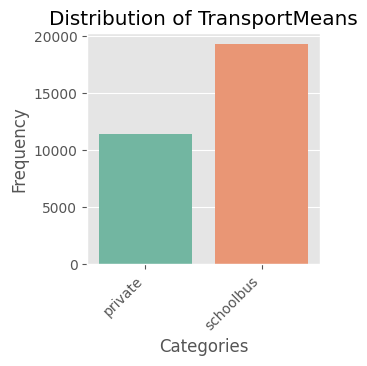

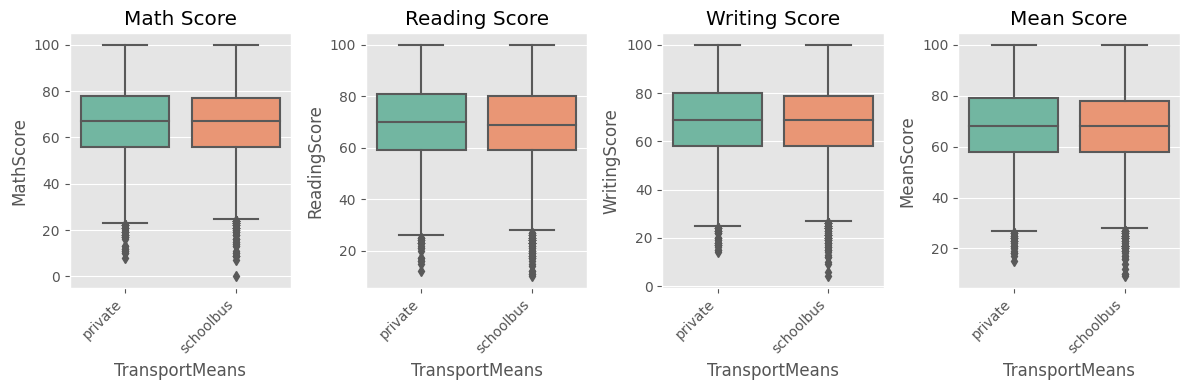

,MathScore,ReadingScore,WritingScore,MeanScore
TransportMeans,,,,
private,66.511354,69.472364,68.509593,68.163880
schoolbus,66.586130,69.321645,68.365009,68.088957


Mean Range: 0.07

** SAVING DATA IS DISABLED **


In [19]:
plot_category_distribution('TransportMeans')

This data is also not balanced, but shows it has no impact on the performance of the students.

In [20]:
column = 'TransportMeans'

analysis = """With a Mean spread of 0.07, whether a student takes the bus or
is privately driven to school has no bearing on their performance."""
display(Markdown(analysis))     
if save_to_disk:
    save_analysis(analysis, f'{column}-analysis.txt')

With a Mean spread of 0.07, whether a student takes the bus or
is privately driven to school has no bearing on their performance.

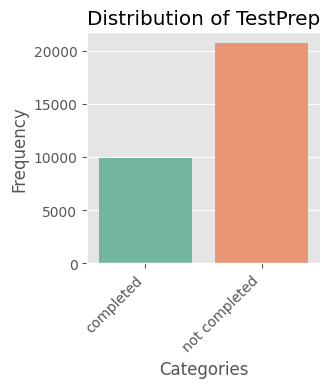

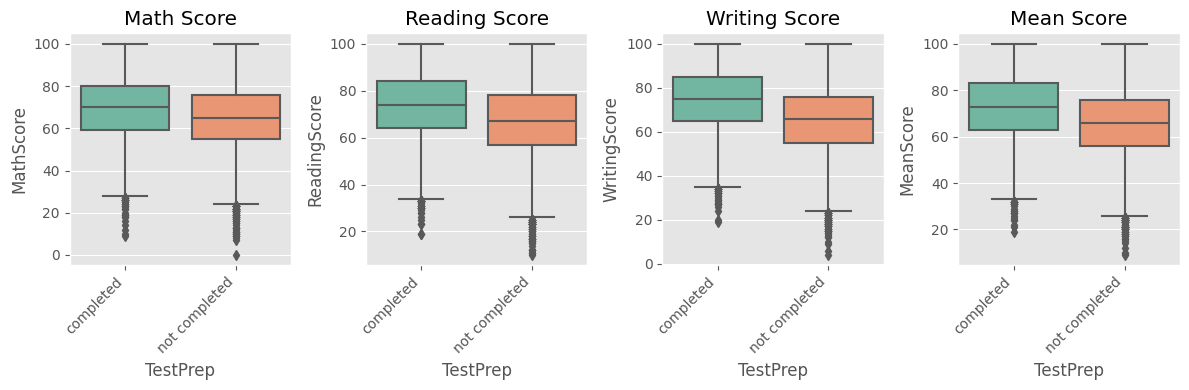

,MathScore,ReadingScore,WritingScore,MeanScore
TestPrep,,,,
completed,69.546660,73.732998,74.703265,72.662280
not completed,65.120323,67.281495,65.394180,65.929227


Mean Range: 6.73

** SAVING DATA IS DISABLED **


In [21]:
plot_category_distribution('TestPrep')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students who did not complete their test prep studies.

Faily obviously, students who completed the test preparation perform  on average 7% better in the end.

**I hypothesize that TestPrep should have an influence on the predicted score.**

In [22]:
column = 'TestPrep'

analysis = f"""Rather obviously whether or not a student completed their test
preparation has a 7 percent impact on their overall performance. I expect
{column} will have measurable impact on the predictive model."""
display(Markdown(analysis))     
if save_to_disk:
    save_analysis(analysis, f'{column}-analysis.txt')

Rather obviously whether or not a student completed their test
preparation has a 7 percent impact on their overall performance. I expect
TestPrep will have measurable impact on the predictive model.

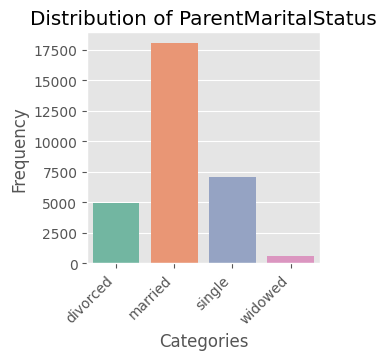

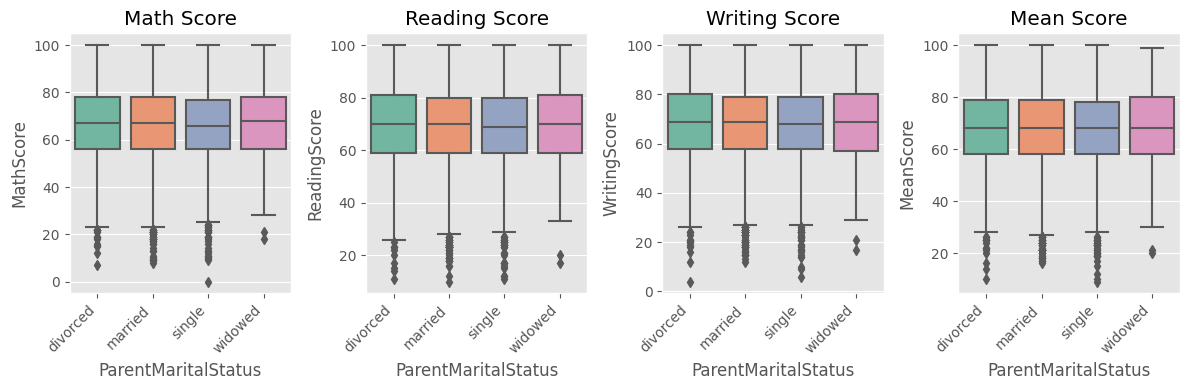

,MathScore,ReadingScore,WritingScore,MeanScore
ParentMaritalStatus,,,,
widowed,67.368866,69.651438,68.563452,68.526227
divorced,66.691197,69.655011,68.799146,68.380972
married,66.650161,69.379561,68.406177,68.144006
single,66.165704,69.157250,68.174440,67.830210


Mean Range: 0.7

** SAVING DATA IS DISABLED **


In [23]:
plot_category_distribution('ParentMaritalStatus')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students with married parents.
Also, students with widowed parents seem to be an outlier and might skew the data somewhat.

Based on the mean score, no significant influence of parental marital status can be determined. After confirmation I will likely drop this feature.

**I hypothesize that ParentMaritalStatus should have an no influence on the predicted score.**

In [24]:
column = 'ParentMaritalStatus'

analysis = f"""{column} has no impact on student performance as can be seen 
from a mean range of 0.7"""
display(Markdown(analysis))    
if save_to_disk:
    save_analysis(analysis, f'{column}-analysis.txt')

ParentMaritalStatus has no impact on student performance as can be seen 
from a mean range of 0.7

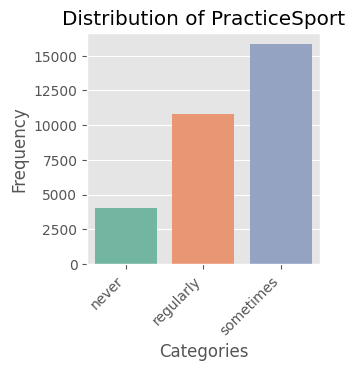

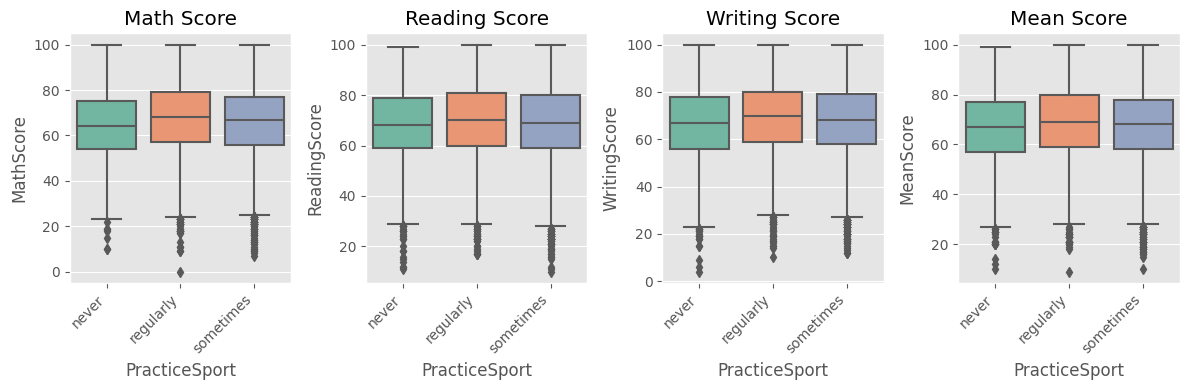

,MathScore,ReadingScore,WritingScore,MeanScore
PracticeSport,,,,
regularly,67.839155,69.943019,69.604003,69.128324
sometimes,66.289258,69.255112,68.090255,67.874968
never,64.171079,68.337662,66.522727,66.346653


Mean Range: 2.78

** SAVING DATA IS DISABLED **


In [25]:
plot_category_distribution('PracticeSport')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students who sometimes do sports.

Based on the mean score, only a minor impact of sports can be determined. After confirmation I will likely drop this feature, unless other features aslone are not sufficient.

**I hypothesize that PracticeSport should have only minor influence on the predicted score.**

In [26]:
column = 'PracticeSport'

analysis = f"""{column} has almost no impact on overall student performance
with a mean range of only **2.78**"""
display(Markdown(analysis))     
if save_to_disk:
    save_analysis(analysis, f'{column}-analysis.txt')

PracticeSport has almost no impact on overall student performance
with a mean range of only **2.78**

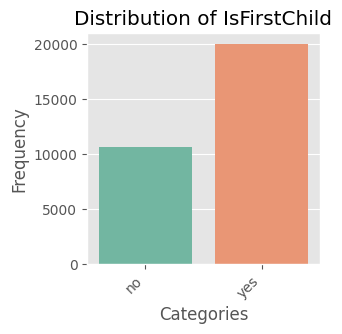

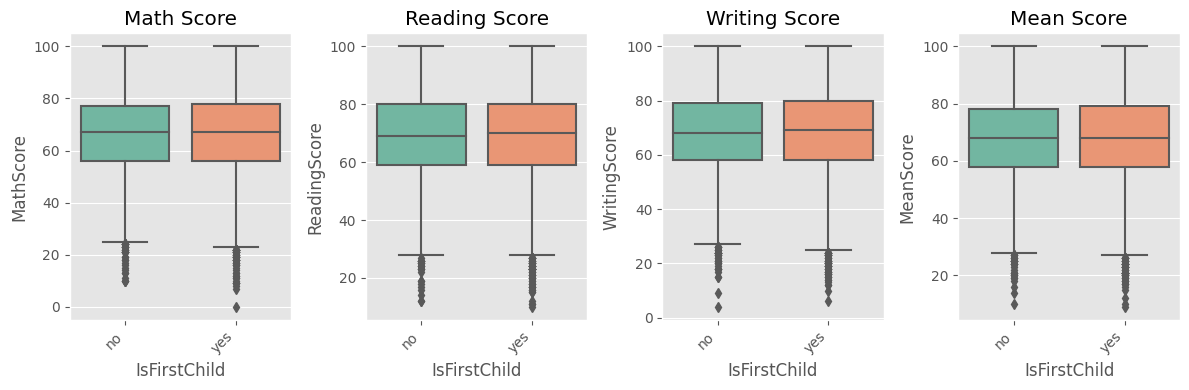

,MathScore,ReadingScore,WritingScore,MeanScore
IsFirstChild,,,,
yes,66.724507,69.508106,68.529371,68.253527
no,66.246832,69.132614,68.210887,67.860160


Mean Range: 0.39

** SAVING DATA IS DISABLED **


In [27]:
plot_category_distribution('IsFirstChild')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students who are the first child.

Based on the mean score, only a minor impact of being first child can be determined. After confirmation I will likely drop this feature, unless other features aslone are not sufficient.

**I hypothesize that IsFirstChild should have only minor influence on the predicted score.**

In [28]:
column = 'IsFirstChild'

analysis = f"""Whether or not a student {column} has almost no impact on 
overall student performance with a mean range of only **0.39**"""
display(Markdown(analysis))     
if save_to_disk:
    save_analysis(analysis, f'{column}-analysis.txt')

Whether or not a student IsFirstChild has almost no impact on 
overall student performance with a mean range of only **0.39**

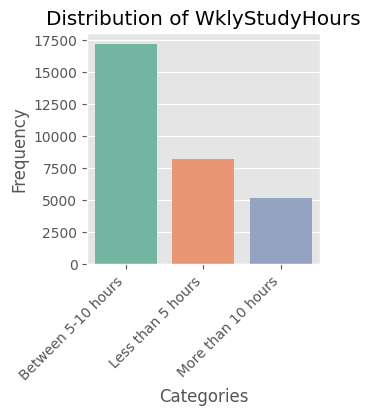

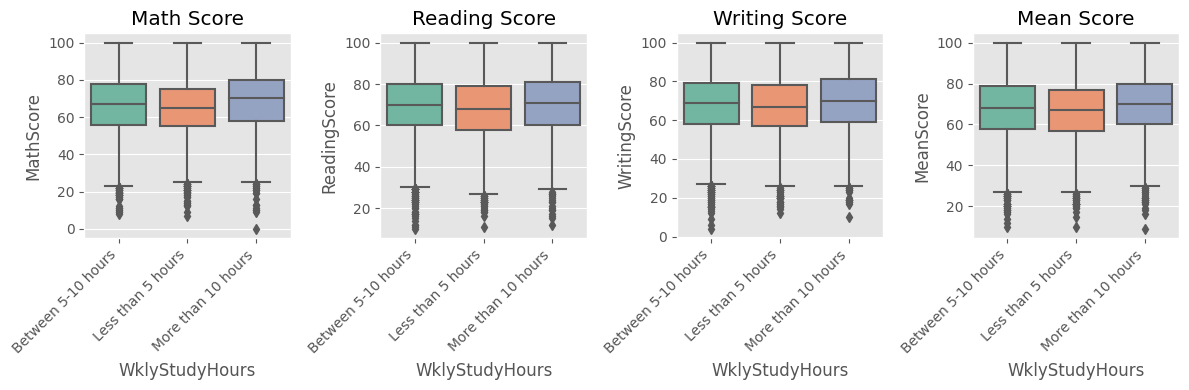

,MathScore,ReadingScore,WritingScore,MeanScore
WklyStudyHours,,,,
More than 10 hours,68.696655,70.365436,69.777778,69.613995
Between 5-10 hours,66.859078,69.654148,68.643800,68.384629
Less than 5 hours,64.580359,68.176135,67.090192,66.611920


Mean Range: 3.0

** SAVING DATA IS DISABLED **


In [29]:
plot_category_distribution('WklyStudyHours')

#### This data is not balanced and will need to be adjusted prior to training the models as it will bias the results towards students who study between 5-10 hours.

Based on the mean score, students who study more than 10h per week have on average 3% better score than student who study <5 hours. This is also not a very signigicant difference. A small biad towards mathematics can be seen 4% difference vs 2 or 3 .. indicating that particularly Maths benefits from extra study time.

**I hypothesize that StudyHours should have only minor influence on the predicted score.**

In [30]:
column = 'WklyStudyHours'

analysis = f"""With a mean range of only 3 percent, the weekly study hours of
as student surprisingly has very little influence on their overall performance
in the exam. Student who study more than 10 hours compared to ones that study
less than 5 hours only perform about 3 percent better on average.
That is really surprising."""
display(Markdown(analysis))     
if save_to_disk:
    save_analysis(analysis, f'{column}-analysis.txt')

With a mean range of only 3 percent, the weekly study hours of
as student surprisingly has very little influence on their overall performance
in the exam. Student who study more than 10 hours compared to ones that study
less than 5 hours only perform about 3 percent better on average.
That is really surprising.

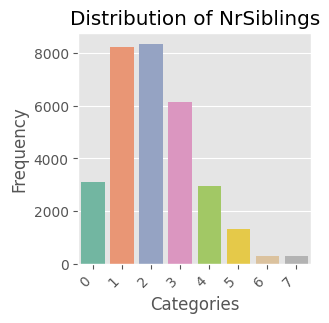

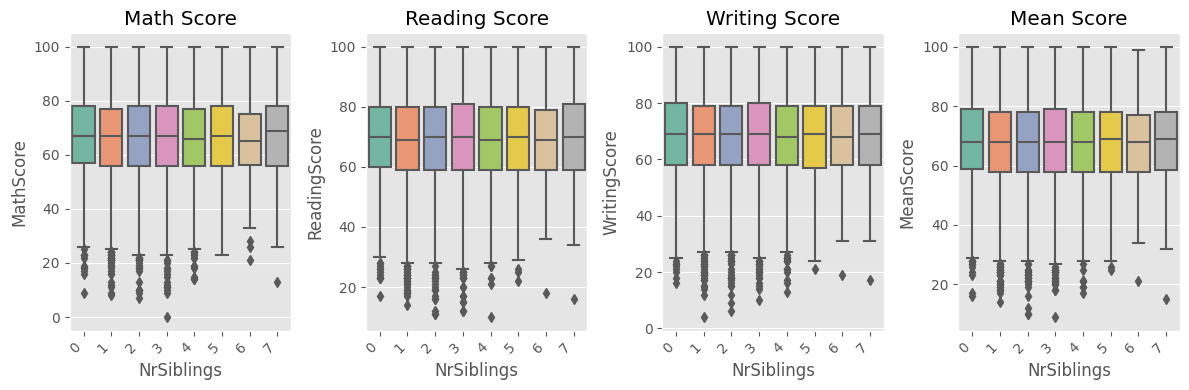

,MathScore,ReadingScore,WritingScore,MeanScore
NrSiblings,,,,
7,67.615120,69.828179,68.986254,68.821306
0,66.819449,69.547812,68.746515,68.369854
3,66.719092,69.488159,68.650498,68.285971
2,66.512557,69.425257,68.441402,68.121382
5,66.630303,69.453788,68.282576,68.119697
1,66.473896,69.259097,68.245345,67.993185
4,66.245495,69.144169,68.073444,67.816729
6,65.917219,68.801325,67.860927,67.562914


Mean Range: 1.26

** SAVING DATA IS DISABLED **


In [31]:
plot_category_distribution('NrSiblings')

#### This data is not balanced.

Based on the mean score, there is practically no difference between being an only child (0) or having 7 siblings ... this indicates that this feature has no bearing on the overall student performance and can be dropped.

**I hypothesize that NrSiblings has NO influence on the predicted score.**

In [32]:
column = 'NrSiblings'

analysis = f"""The number of siblings has no bearing on the students performace
most evident by the fact that according to the dataset, students with ZERO
or 7(!) siblings perform the same in the exam. This veriable will not be a
significant contributer to the model."""
display(Markdown(analysis)) 
if save_to_disk:    
    save_analysis(analysis, f'{column}-analysis.txt')

The number of siblings has no bearing on the students performace
most evident by the fact that according to the dataset, students with ZERO
or 7(!) siblings perform the same in the exam. This veriable will not be a
significant contributer to the model.

## Assess distribution of numerical data

In [33]:
columns = ['MathScore', 'ReadingScore', 'WritingScore','MeanScore']
summaries_dict = {}

for column in columns:
    summary = df[column].describe()
    summaries_dict[column] = summary

# Convert the dictionary of summaries into a DataFrame
summaries_df = pd.DataFrame(summaries_dict)

# Display DataFrames
summaries_df

,MathScore,ReadingScore,WritingScore,MeanScore
count,30641.000000,30641.000000,30641.000000,30641.000000
mean,66.558402,69.377533,68.418622,68.116739
std,15.361616,14.758952,15.443525,14.456619
min,0.000000,10.000000,4.000000,9.000000
25%,56.000000,59.000000,58.000000,58.000000
50%,67.000000,70.000000,69.000000,68.000000
75%,78.000000,80.000000,79.000000,79.000000
max,100.000000,100.000000,100.000000,100.000000


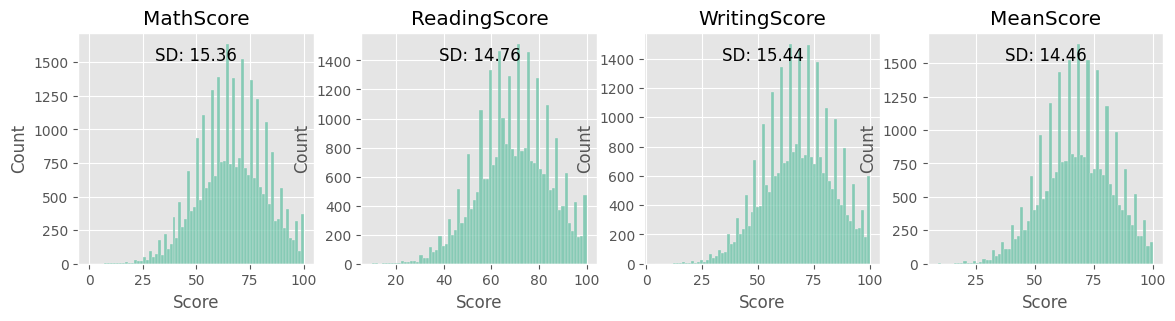

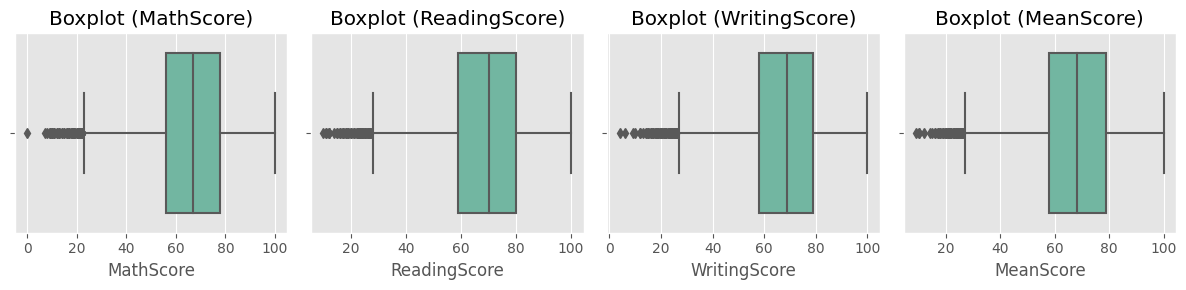

In [34]:
columns = ['MathScore', 'ReadingScore', 'WritingScore','MeanScore']
plt.figure(figsize=(14, 3))

for i, column in enumerate(columns, start=1):
    plt.subplot(1, 4, i) 
    sns.histplot(df[column], fill=True)
    plt.title(column)
    plt.xlabel('Score')
    plt.ylabel('Count')
    
    #add standard deviation to plots
    std_dev = df[column].std()
    plt.text(x=0.5, y=0.9, s=f'SD: {std_dev:.2f}', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=12)

if save_to_disk:
    save_plot(plt, f'Numerical-distribution.png')

# add box plots
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
# Columns to plot
for i, col in enumerate(columns):
    ax = axs[i]
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"Boxplot ({col})")

plt.tight_layout()

if save_to_disk:
    save_plot(plt, f'Numerical-boxplots.png')
    
plt.show()

### Create a subplot of KDE diagrams to visualize density/concentration of data

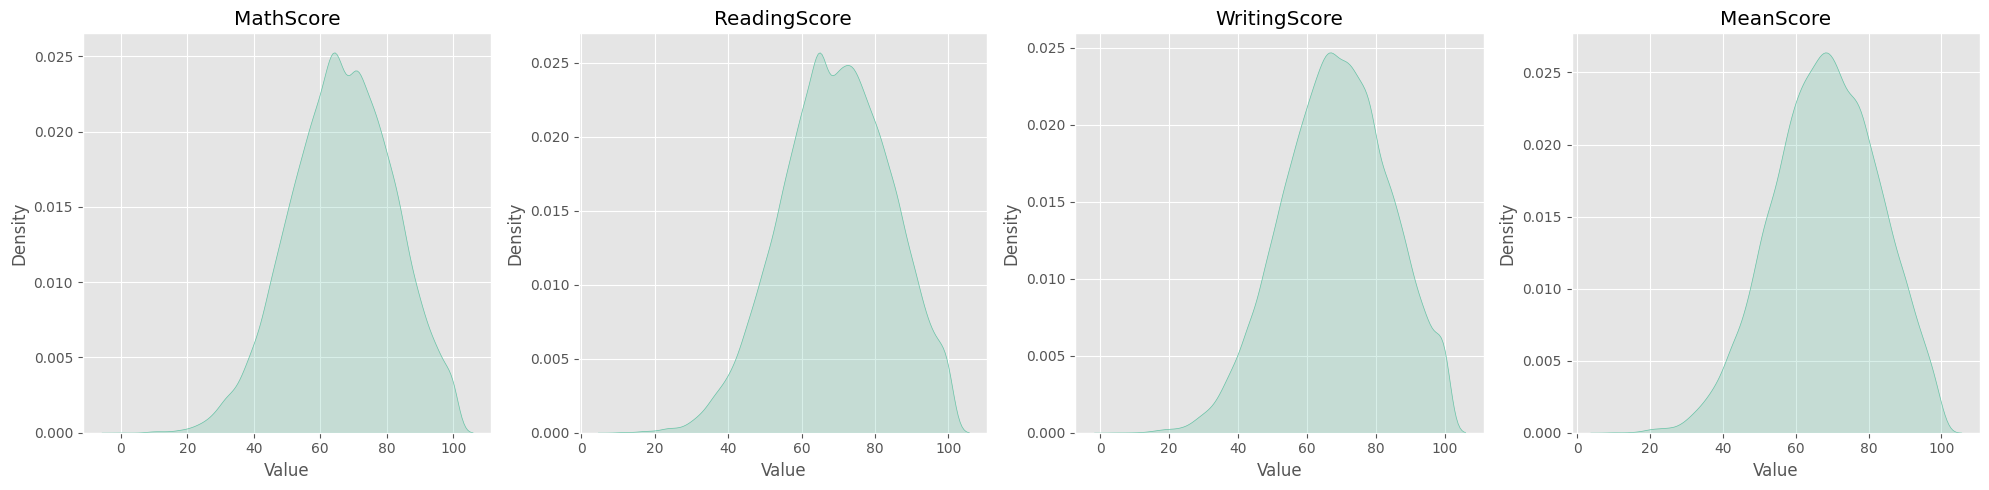

In [35]:
plt.figure(figsize=(20, 5))

for i, column in enumerate(columns, start=1):
    plt.subplot(1, 4, i) 
    sns.kdeplot(df[column], fill=True)
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Density')

plt.tight_layout()
if save_to_disk:
    save_plot(plt, f'Numerical-kde.png')
plt.show()


### Visually the data seems to follow a standard 'bell curve' and appears normally distributed, which is very helpful for model fitting.
A standard deviation of 15 indicates the students performance are reasonably close to the mean grade. To further analyse the normal distribution I will plot QQ diagrams below:

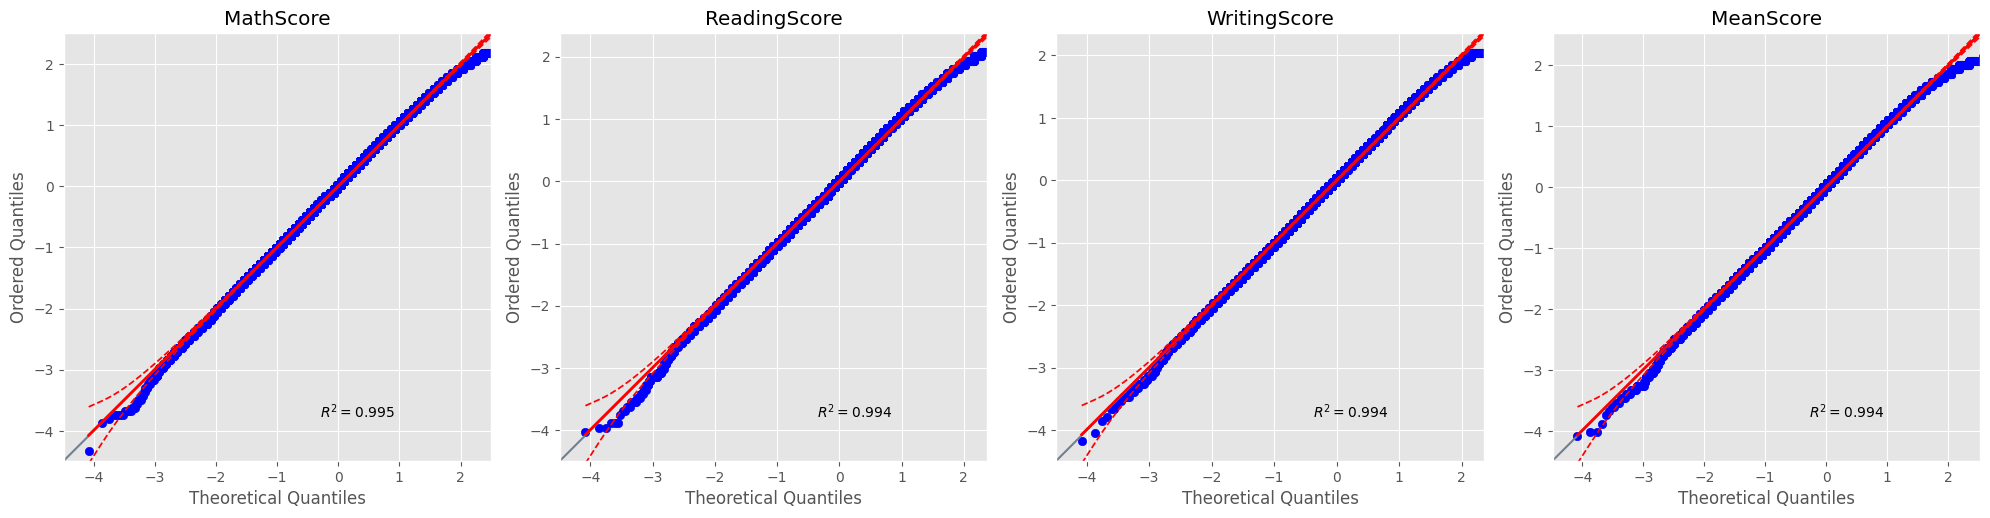

In [36]:
plt.figure(figsize=(20, 5))

for i, column in enumerate(columns, start=1):
    plt.subplot(1, 4, i) 
    data = df[column]
    pg.qqplot(df[column], dist='norm')
    plt.title(column)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Quantiles')

plt.tight_layout()
if save_to_disk:
    save_plot(plt, f'Numerical-qq.png')
plt.show()

#### The QQ plots are very closely aligned to the diagonal indicating an very good normal distribution especially around the mean. The values deviate slightly at the ends indicating some possible outliers skewing the normality of the data. This will hopefully not influence any linear regression models to be applied but might need to be dealt with if accuracy becomes an issue.

The R2 value of 0.994+ is also very good indicator of normalness.

Testing for shapiro wilk, we get a dissappointing result:

In [37]:
shapiro_results = []

# Loop and perform the Shapiro-Wilk test
for column in columns:
    test_result = pg.normality(data=df[column], alpha=0.05)
    test_result['Variable'] = column
    shapiro_results.append(test_result)

# add to DataFrame
shapiro_results_df = pd.concat(shapiro_results, ignore_index=True)

shapiro_results_df

/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal,Variable
0,0.995355,2.231806e-29,False,MathScore
1,0.993568,6.197050e-34,False,ReadingScore
2,0.993718,1.361163e-33,False,WritingScore
3,0.994184,1.731815e-32,False,MeanScore


The Shapiro_wilk check seems to indicate that the data is not normal, despite the R2 values and visual confirmation of the Q-Q Plots. However, as the warninig suggests, the test is known to get more sensitive to even small deviations on very large datasets. For this reason, I will press on with the data preparation, under the assumption that data normalcy won't be an issue.